<a href="https://colab.research.google.com/github/constantinpape/training-deep-learning-models-for-vison/blob/master/day3/unet_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a U-net

The [U-net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) is a very popular model architecture for segmentation in bioimage analysis.
Here, we will train a 2D U-net for nuclei segmentation, using data from the [Kaggle Nucleus Segmentation challenge](https://www.kaggle.com/c/data-science-bowl-2018).

## The libraries

In [2]:
%matplotlib inline
%load_ext tensorboard
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

from pathlib import Path

In [3]:
%load_ext autoreload
%aimport utils
%autoreload 1

In [4]:
from utils import UNet, EMDataset, split_with_overlap, DiceLoss

## Data loading and preprocessing

In [5]:
data_dir = Path(r"/g/kreshuk/buglakova/data/cryofib")
images_dir = data_dir / "F107_bin2_619-639_frames" / "train"
labels_dir = data_dir / "corrected_labels" / "train"

In [4]:
def show_one_image(image_path):
  image = imageio.imread(image_path)
  plt.imshow(image)

In [5]:
image = list(images_dir.glob("*.tiff"))[0]
mask = list(labels_dir.glob("*.tiff"))[0]

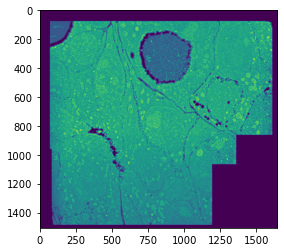

In [6]:
show_one_image(image)

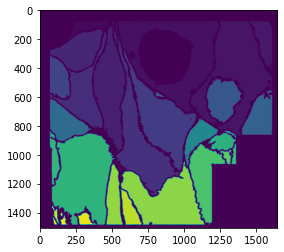

In [7]:
show_one_image(mask)

In [8]:
image = imageio.imread(list(images_dir.glob("*.tiff"))[5])
mask = imageio.imread(list(labels_dir.glob("*.tiff"))[5])

In [10]:
tile_layout, ind_min, ind_max = split_with_overlap(image, tile_size=(1024, 1024), overlap=0.1)

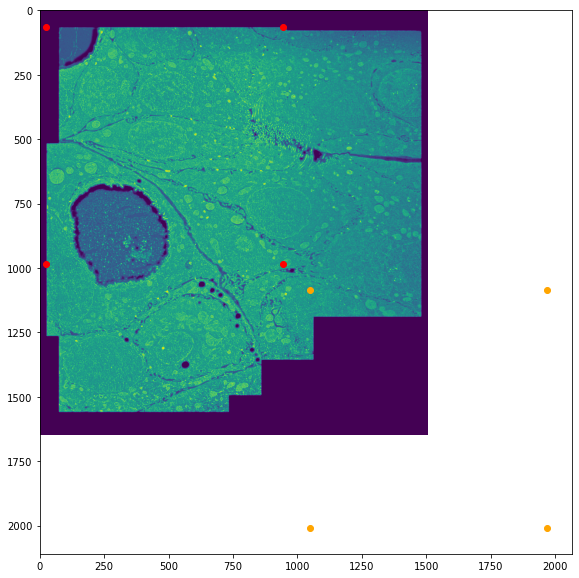

In [11]:
plt.figure(figsize=(10, 10))
plt.imshow(image.T)
plt.scatter(ind_min[0, :], ind_min[1, :], c="r")
plt.scatter(ind_max[0, :], ind_max[1, :], c="orange")

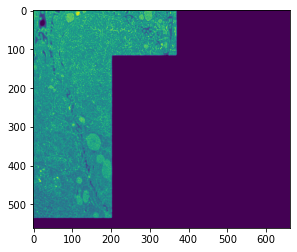

In [12]:
n = -1
plt.imshow(image[ind_min[:, n][0]:ind_max[:, n][0], ind_min[:, n][1]:ind_max[:, n][1], ...])

Load the dataset and visualize it with a simple function:

In [18]:
tile_size = (512, 512)

In [19]:
train_images_dir = data_dir / "F107_bin2_619-639_frames" / "train"
train_labels_dir = data_dir / "corrected_labels" / "train"
train_data = EMDataset(train_images_dir, train_labels_dir, tile_size=tile_size)
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)

In [20]:
def show_random_dataset_image(dataset):
    idx = np.random.randint(0, len(dataset))    # take a random sample
    img, mask = dataset[idx]                    # get the image and the nuclei masks
    f, axarr = plt.subplots(1, 2)               # make two plots on one figure
    axarr[0].imshow(img[0])                     # show the image
    axarr[1].imshow(mask[0])                    # show the masks
    _ = [ax.axis('off') for ax in axarr]        # remove the axes
    print('Image size is %s' % {img[0].shape})
    plt.show()

Image size is {torch.Size([512, 512])}


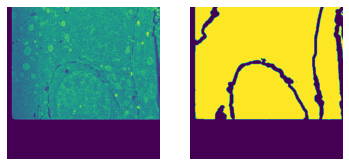

In [21]:
show_random_dataset_image(train_data)

And the same for the validation data:

In [22]:
test_images_dir = data_dir / "F107_bin2_619-639_frames" / "test"
test_labels_dir = data_dir / "corrected_labels" / "test"
test_data = EMDataset(test_images_dir, test_labels_dir, tile_size=tile_size)
val_loader = DataLoader(test_data, batch_size=1)

Image size is {torch.Size([512, 512])}


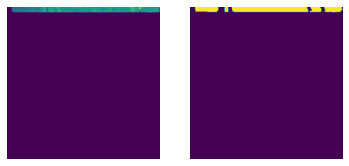

In [23]:
show_random_dataset_image(test_data)

## Run tensorboard

In [3]:
%tensorboard --logdir runs

Reusing TensorBoard on port 6008 (pid 144186), started 6 days, 4:34:41 ago. (Use '!kill 144186' to kill it.)

## Load model and predict for all images

In [91]:
class EMDataset(Dataset):
    """ A PyTorch dataset to load volume EM images and manually segmented masks """
    def __init__(self, img_path, mask_path, tile_size=(512, 512), transform=None, overlap=0.3):
        self.img_path = Path(img_path)  # the directory with all the training samples
        self.mask_path = Path(mask_path)  # the directory with all the training samples
        self.img_list = sorted(list(self.img_path.glob("*.tiff"))) # list the samples
        self.mask_list = sorted(list(self.mask_path.glob("*.tiff")))

        self.tile_size = tile_size
        self.transform = transform    # transformations to apply to both inputs and targets
        #  transformations to apply just to inputs
        self.inp_transforms = [transforms.ToTensor()]
        # transformations to apply just to targets
        self.mask_transforms = transforms.ToTensor()

        self.overlap = overlap

    # get the total number of samples
    def __len__(self):
        return len(self.img_list)


    # fetch the training sample given its index
    def __getitem__(self, idx):
        img_path = self.img_list[idx]
        mask_path = self.mask_list[idx]
        # we'll be using Pillow library for reading files
        # since many torchvision transforms operate on PIL images 
        image = imageio.imread(img_path)
        mask = imageio.imread(mask_path)
        
        tile_layout, ind_min, ind_max = split_with_overlap(image, tile_size=self.tile_size, overlap=self.overlap)
        n_tiles = ind_min.shape[1]
        # print(n_tiles, ind_min.shape, ind_max.shape)

        # Crop random tile
        rand_n = np.random.randint(low=0, high=n_tiles)
        # print(rand_n)

        img_tile = crop_tile(image, ind_min[:, rand_n], ind_max[:, rand_n])
        mask_tile = crop_tile(mask, ind_min[:, rand_n], ind_max[:, rand_n])

        # Convert mask into channels
        mask_tile = convert_to_chan(mask_tile)
        # print("Converted tile shape ", mask_tile.shape)

        # Apply transformations
        inp_transforms_idx = self.inp_transforms.copy()
        inp_transforms_idx.append(transforms.Normalize([np.mean(image)], [np.std(image)]))
        inp_transforms_idx = transforms.Compose(self.inp_transforms)
        img_tile = inp_transforms_idx(img_tile)
        mask_tile = self.mask_transforms(mask_tile)

        # print("tile shape", img_tile.shape)
        if self.transform is not None:
            img_tile, mask_tile = self.transform([img_tile, mask_tile])
        return img_tile, mask_tile


    def split_tiles(self, idx):
        pass


    def get_tile_list(self, idx):
        img_path = self.img_list[idx]
        image = imageio.imread(img_path)
        tile_layout, ind_min, ind_max = split_with_overlap(image, tile_size=self.tile_size, overlap=0.3)

        tiles = [crop_tile(image, ind_min[:, n], ind_max[:, n]) for n in range(ind_min.shape[1])]

        # Apply transformations
        inp_transforms_idx = self.inp_transforms.copy()
        inp_transforms_idx.append(transforms.Normalize([np.mean(image)], [np.std(image)]))
        inp_transforms_idx = transforms.Compose(self.inp_transforms)
        tiles = [inp_transforms_idx(tile) for tile in tiles]

        return image, tile_layout, ind_min, ind_max, tiles

    def get_image(self, idx):
        img_path = self.img_list[idx]
        image = imageio.imread(img_path)
        
        return image


    def get_mask(self, idx):
        mask_path = self.mask_list[idx]
        mask = imageio.imread(mask_path)

        return mask


    def _stitch_tiles(self, ind_min, ind_max, predictions, image_shape):
        '''
            Predictions: array in format of NCHW, where N is number of tiles
        '''
        stitched = np.zeros((predictions.shape[1], *image_shape))
        stitched_n = np.zeros((predictions.shape[1], *image_shape))

        for i, i_min, i_max, tile in zip(range(len(tiles)), ind_min.T, ind_max.T, predictions):
            x_size = stitched.shape[1] - i_min[0]
            y_size = stitched.shape[2] - i_min[1]
            stitched[:, i_min[0]:i_max[0], i_min[1]:i_max[1]] += tile[:, 0:x_size, 0:y_size]
            stitched_n[:, i_min[0]:i_max[0], i_min[1]:i_max[1]] += 1

        stitched_n[stitched_n == 0] = 1

        stitched = stitched / stitched_n

        return stitched


    def predict_boundaries(self, model_path):
        # Load network
        # 4 because my GPU is number 4
        if torch.cuda.is_available():
            print("GPU is available")
            device = torch.device(4)
        else:
            print("GPU is not available")
            device = torch.device("cpu")

        model_loaded = UNet(1, 4, final_activation=nn.Sigmoid())
        checkpoint = torch.load(model_path)
        model_loaded.load_state_dict(checkpoint['model_state_dict'])
        model_loaded = model_loaded.to(device)


        self.stitched_predictions = []
        for i in trange(len(self.img_list)):
            image, tile_layout, ind_min, ind_max, tiles = self.get_tile_list(i)

            predictions = []

            for tile in tiles:
                predictions.append(model_loaded(tile[None, ...].to(device)).to("cpu").detach().numpy()[0, ...])

            predictions = np.array(predictions)
            stitched = self._stitch_tiles(ind_min, ind_max, predictions, image.shape)
            self.stitched_predictions.append(stitched)
    

In [99]:
from utils import crop_tile, stack_chan
from tqdm import trange

In [93]:
data = EMDataset(images_dir, labels_dir)

In [94]:
model_path = "models/unet.pt"

In [95]:
data.predict_boundaries(model_path)

GPU is available


100%|██████████| 9/9 [00:09<00:00,  1.11s/it]


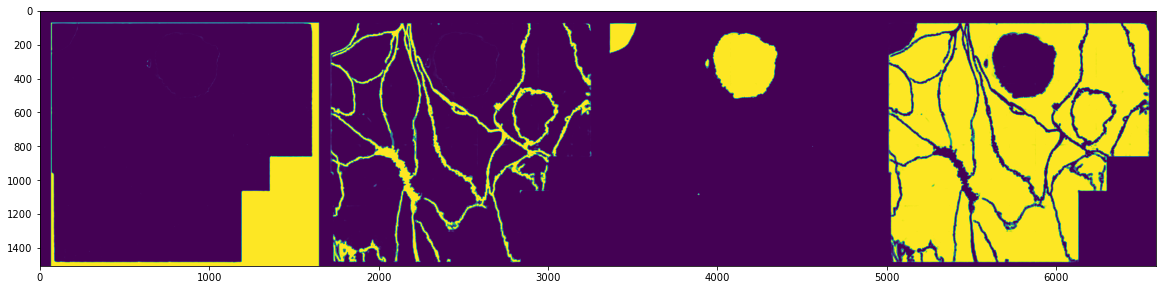

In [101]:
plt.figure(figsize=(20, 5))
plt.imshow(stack_chan(data.stitched_predictions[0][None, ...]))

In [9]:
image, tile_layout, ind_min, ind_max, tiles = data.get_tile_list(1)

## Load model

In [10]:
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device(4)
else:
    print("GPU is not available")
    device = torch.device("cpu")

GPU is available


In [11]:
model_path = "models/unet.pt"

model_loaded = UNet(1, 4, final_activation=nn.Sigmoid())
checkpoint = torch.load(model_path)
model_loaded.load_state_dict(checkpoint['model_state_dict'])
model_loaded = model_loaded.to(device)

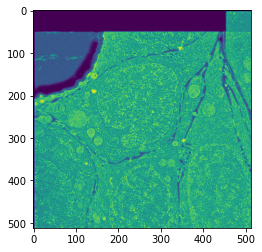

In [12]:
plt.imshow(tiles[0][0, :, :])

In [13]:
import gc

gc.collect()

22

In [14]:
out_channels = 4
predictions = []

for i, tile in enumerate(tiles):
    predictions.append(model_loaded(tile[None, ...].to(device)).to("cpu").detach().numpy()[0, ...])


0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3
0
1
2
3


In [15]:
predictions = np.array(predictions)

In [16]:
predictions.shape

(25, 4, 512, 512)

In [17]:
model_loaded.eval()

prediction = model_loaded(tile[0][None, :, :, :])

IndexError: too many indices for tensor of dimension 2

In [53]:
tiles = [crop_tile(image, ind_min[:, n], ind_max[:, n]) for n in range(ind_min.shape[1])]

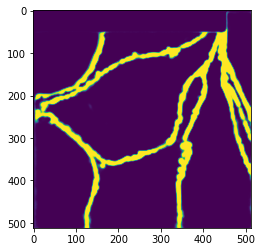

In [23]:
plt.imshow(predictions[0, 1, :, :])

In [70]:
stitched.shape

(4, 1506, 1647)

In [71]:
predictions.shape

(25, 4, 512, 512)

In [ ]:
model_path = "models/unet.pt"
out_channels = 4



        

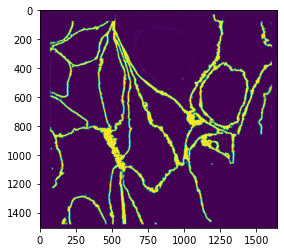

In [82]:
plt.imshow(stitched[1, :, :])

In [72]:
for i, i_min, i_max, tile in zip(range(len(tiles)), ind_min.T, ind_max.T, predictions):
    x_size = stitched.shape[1] - i_min[0]
    y_size = stitched.shape[2] - i_min[1]
    stitched[:, i_min[0]:i_max[0], i_min[1]:i_max[1]] += tile[:, 0:x_size, 0:y_size]
    stitched_n[:, i_min[0]:i_max[0], i_min[1]:i_max[1]] += 1

stitched_n[stitched_n == 0] = 1

In [73]:
print(stitched_n)

[[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 4. 4. 4.]
  [1. 1. 1. ... 4. 4. 4.]
  [1. 1. 1. ... 4. 4. 4.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 4. 4. 4.]
  [1. 1. 1. ... 4. 4. 4.]
  [1. 1. 1. ... 4. 4. 4.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 4. 4. 4.]
  [1. 1. 1. ... 4. 4. 4.]
  [1. 1. 1. ... 4. 4. 4.]]

 [[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 4. 4. 4.]
  [1. 1. 1. ... 4. 4. 4.]
  [1. 1. 1. ... 4. 4. 4.]]]


In [74]:
stitched = stitched / stitched_n

In [75]:
stitched.shape

(4, 1506, 1647)

In [76]:
stitched[3, :, :]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.98723490e-20, 1.00888845e-19, 1.03061968e-19],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.69202235e-19, 5.89441696e-19, 4.35217211e-19],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        9.51363064e-20, 2.10627645e-19, 1.28764904e-19]])

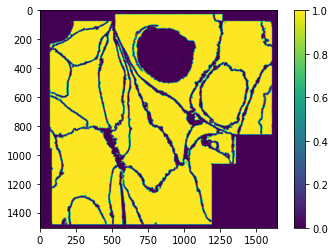

In [77]:
plt.imshow(stitched[3, :, :])
plt.colorbar()

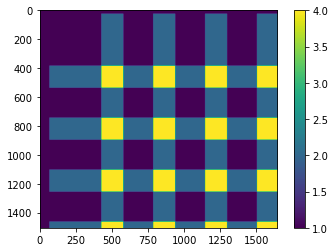

In [78]:
plt.imshow(stitched_n[1, :, :])
plt.colorbar()

/tmp/ipykernel_93699/2869865819.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(stitched / stitched_n)


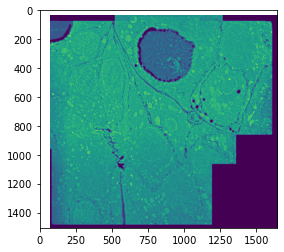

In [85]:
plt.imshow(stitched / stitched_n)

In [57]:
ind_min.shape

(2, 25)

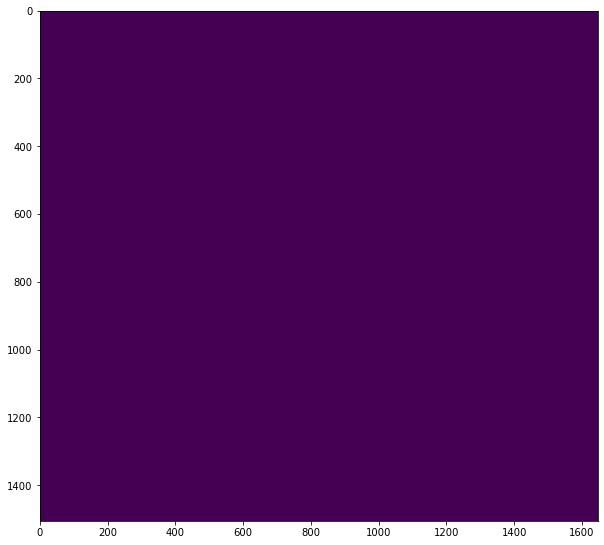

In [58]:
plt.figure(figsize=(10, 10))
plt.imshow(stitched - image)

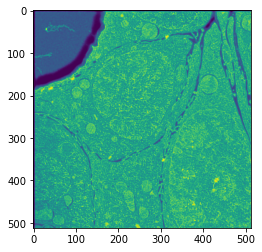

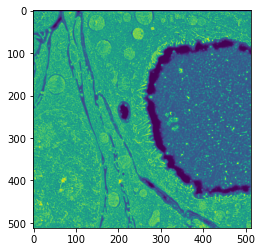

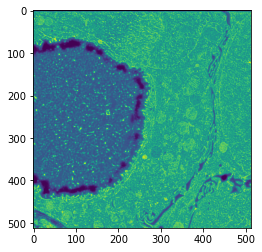

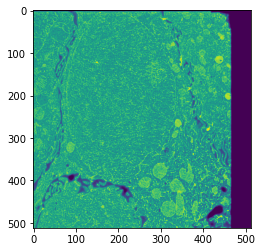

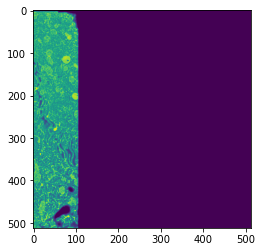

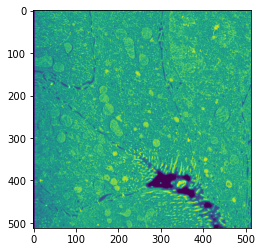

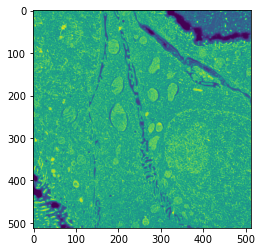

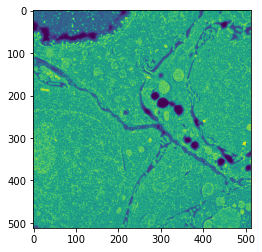

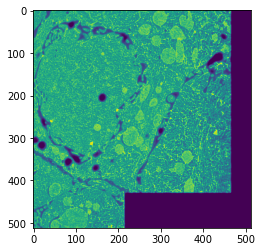

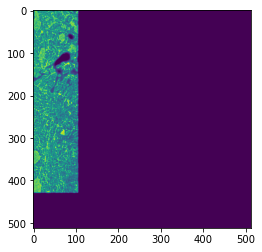

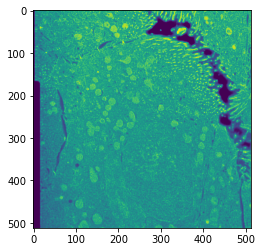

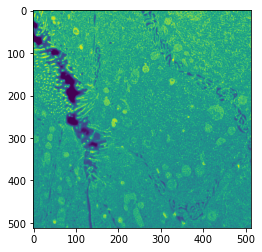

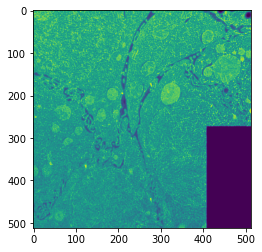

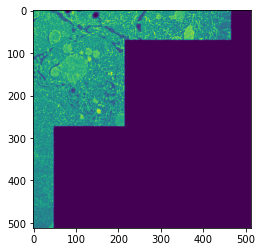

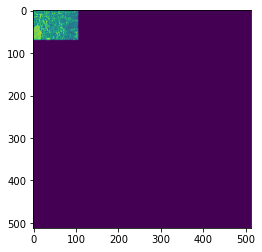

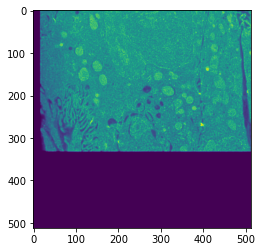

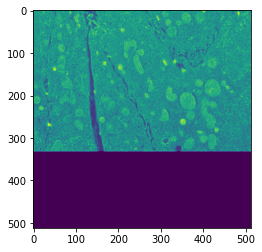

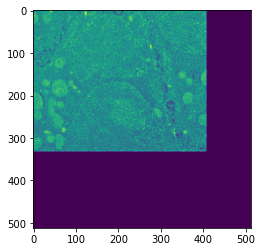

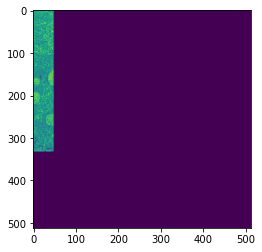

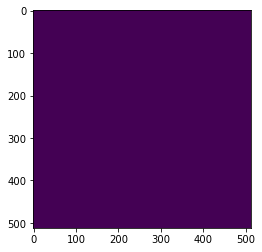

In [33]:
for tile in tiles:
    plt.imshow(tile)
    plt.show()

In [ ]:
plt.imshow(image)

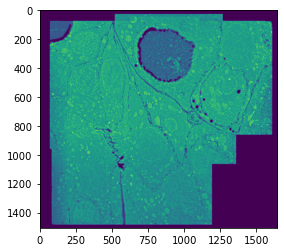

In [59]:
plt.imshow(image)

In [10]:
model_loaded()

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (base): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), pad

In [8]:
checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'val_loss'])

In [80]:
tile = test_data[0]

In [85]:
tile[0].shape

torch.Size([1, 512, 512])

In [87]:
model_loaded.eval()

prediction = model_loaded(tile[0][None, :, :, :])

0
1
2
3


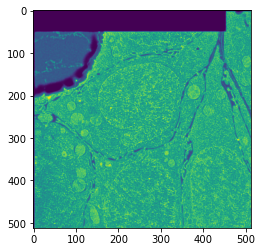

In [90]:
plt.imshow(tile[0][0, :, :])

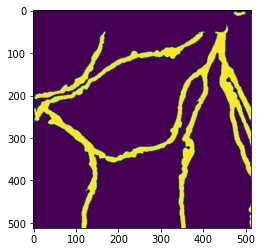

In [95]:
plt.imshow(tile[1][2, :, :])

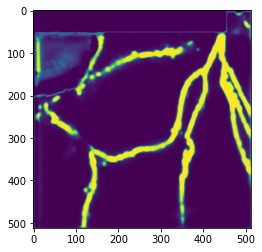

In [101]:
plt.imshow(prediction.detach()[0, 2, :, :])

In [50]:
net

UNet(
  (encoder): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
    )
  )
  (base): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), pad

In [ ]:
tb_logg

## Additional Exercises 

1. Implement and compare at least 2 of the following architecture variants of the U-Net:
    * use [Dropout](https://pytorch.org/docs/stable/nn.html#dropout-layers) in the decoder path
    * use [BatchNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) to normalize layer inputs
    * use [GroupNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.GroupNorm) to normalize convolutional group inputs
    * use [ELU-Activations](https://pytorch.org/docs/stable/nn.html#torch.nn.ELU) instead of ReLU-Activations

2. Use the Dice coefficient as loss function. Before we only used it for validation, but it is differentiable and can thus also be used as loss. Compare to the results from exercise 2. 
Hint: The optimizer we use finds minima of the loss, but the minimal value for the Dice coefficient corresponds to a bad segmentation. How do we need to change the Dice coefficient to use it as loss nonetheless?

3. Add one more layer to the U-net model (currently it has 4). Compare the results.

## Advanced Exercises

1. Visualize the graph (model) that we are using with TensorBoard
2. Write your own data transform (e.g., RandomRotate)